In [ ]:
!wget http://www.ivan-sipiran.com/downloads/data_patterns2.zip
!unzip data_patterns2.zip

--2025-09-10 12:38:30--  http://www.ivan-sipiran.com/downloads/data_patterns2.zip
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28575047 (27M) [application/zip]
Saving to: ‘data_patterns2.zip’

data_patterns2.zip  100%[===================>]  27.25M  44.2MB/s    in 0.6s    

2025-09-10 12:38:31 (44.2 MB/s) - ‘data_patterns2.zip’ saved [28575047/28575047]

Archive:  data_patterns2.zip
   creating: data/
  inflating: data/class_labels.csv   
  inflating: data/0.jpg              
  inflating: data/6.jpg              
  inflating: data/36.jpg             
  inflating: data/92.jpg             
  inflating: data/210.jpg            
   creating: data/patrones/
   creating: data/patrones/69c/
  inflating: data/patrones/69c/69c_pattern.png  
   creating: data/patrones/2a/
  inflating: data/patrones/2a/2a_pattern.png  
   creating:

# Transfer Learning

En este notebook resolveremos un problema real usando redes pre-entrenadas y transfer learning.

## Patrones geométricos de Kunisch
En el año 1998, Norbert Kunisch (un reconocido arqueólogo clásico alemán) publicó su libro "Ornamente Geometrischer Vasen", en donde clasificó diferentes patrones geométricos de vasijas griegas que se encuentran en diferentes museos de Europa. Su trabajo fue muy importante para determinar tiempos y ubicaciones de muchos objetos esparcidos por todo el continente.

Su libro es un compendio de los diferentes patrones geométricos presentes en vasijas y las anotaciones textuales de los patrones en diferentes idiomas.

<img src="http://www.ivan-sipiran.com/downloads/0.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/6.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/36.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/92.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/210.jpg" alt="Test" height="200" />








# El problema

En el museo de arqueología Schloss Eggenberg quieren realizar un análisis automático de patrones en vasijas usando el compendio de Kunisch. Para esto nosotros realizamos primero un trabajo de escaneo del libro entero y de OCR para extraer tanto los patrones como las anotaciones textuales.

Como resultado tenemos 348 patrones, clasificados en seis clases:

*   Ornamentos circulares
*   Ornamentos triangulares
*   Ornamenros rectangulares
*   Pictografías
*   Trazos y líneas
*   Romboidales

Nuestro primer objetivo es encontrar una forma de lograr una alta eficacia de clasificación de estos patrones. Sin embargo, al tener muy poca data, trataremos de resolverlo con la técnica dle transfer learning.



# La Solución

Primero creamos nuestras tres colecciones de datos: train, val y test. Los datos de train serán usados para entrenar el modelo, los datos de validación serán usados para probar el modelo durante entrenamiento, y los datos de test serán usados para evaluar el performance final del modelo.

Hacemos un poco de data engineering para crear nuestras colecciones.

*   Datos de train: 70%
*   Datos de val: 10%
*   Datos de test: 20%

La partición se hace dentro de cada clase para asegurar representatividad en cada clase.



## Creación y preparación del dataset

In [ ]:
import pandas as pd
import math
import random
import os
import shutil

random.seed(30)

# Leemos las etiquetas desde un cvs
df = pd.read_csv('data/class_labels.csv', header=None)
# Extrae la primera columna que contiene las etiquetas de la clase
classes = df[1].unique()
# Reemplaza los espacio por guiones
classesFinal = [cl.replace(' ', '_') for cl in classes]
print(classesFinal)

try:
  os.mkdir('dataset')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

# Creamos las carpeta de train, val, y test
try:
  os.mkdir('dataset/train')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

try:
  os.mkdir('dataset/test')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

try:
  os.mkdir('dataset/val')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

# Para cada clase creamos una carpeta
for cl in classesFinal:
  try:
    os.mkdir(os.path.join('dataset', "train", cl))
  except OSError:
    print (f"No se pudo crear folder train {cl}")
  else:
    print (f"Se creó folder train {cl}")

  try:
    os.mkdir(os.path.join('dataset', "test", cl))
  except OSError:
    print (f"No se pudo crear folder test {cl}")
  else:
    print (f"Se creó folder test {cl}")

  try:
    os.mkdir(os.path.join('dataset', "val", cl))
  except OSError:
    print (f"No se pudo crear folder val {cl}")
  else:
    print (f"Se creó folder val {cl}")


['circular_ornaments', 'triangular_ornaments', 'rectangular_ornaments', 'pictographics', 'lozenge', 'strokes_and_lines']
Se creó folder dataset
Se creó folder dataset
Se creó folder dataset
Se creó folder dataset
Se creó folder train circular_ornaments
Se creó folder test circular_ornaments
Se creó folder val circular_ornaments
Se creó folder train triangular_ornaments
Se creó folder test triangular_ornaments
Se creó folder val triangular_ornaments
Se creó folder train rectangular_ornaments
Se creó folder test rectangular_ornaments
Se creó folder val rectangular_ornaments
Se creó folder train pictographics
Se creó folder test pictographics
Se creó folder val pictographics
Se creó folder train lozenge
Se creó folder test lozenge
Se creó folder val lozenge
Se creó folder train strokes_and_lines
Se creó folder test strokes_and_lines
Se creó folder val strokes_and_lines


In [ ]:
dataset = dict()

# Crea un diccionario con los datos por clase
for index, cl in enumerate(classes):
    grouped_data = df.groupby(1).get_group(cl)[0].tolist()
    dataset[classesFinal[index]] = grouped_data

# Mostramos la cantidad de elementos por clase
# k es el nombre de la clase
# v es el nombre del archivo
for k,v in dataset.items():
    print(f'Class: {k}, Length: {len(v)}')

# División de datos
for k,v in dataset.items():
    valNumber = math.ceil(0.1 * len(v)) # 10%
    testNumber = math.ceil(0.2 * len(v)) # 20%
    trainNumber = len(v) - valNumber - testNumber # 70%

    # Baraja y asigna cada subconjunto
    random.shuffle(v)
    elemTrain = v[:trainNumber]
    elemVal = v[trainNumber:trainNumber+valNumber]
    elemTest = v[trainNumber+valNumber:]

    assert (valNumber + testNumber + trainNumber) == len(v)

    pathTrain = './dataset/train/'
    pathSource = './data/patrones/'

    #Copiar archivos de train
    for elem in elemTrain:
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathTrain, k))

    pathTest = './dataset/test/'
    pathSource = './data/patrones/'

    #Copiar archivos de test
    for elem in elemTest:
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathTest, k))

    pathVal = './dataset/val/'
    pathSource = './data/patrones/'

    #Copiar archivos de train
    for elem in elemVal:
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathVal, k))

Class: circular_ornaments, Length: 72
Class: triangular_ornaments, Length: 81
Class: rectangular_ornaments, Length: 87
Class: pictographics, Length: 26
Class: lozenge, Length: 46
Class: strokes_and_lines, Length: 36


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy

pathDataset = 'dataset/'

# Preparamos el dataset de entrenamiento, validación y test
# Carga las imágenes clasificándolas según el nombre de la carpeta
train_dataset = torchvision.datasets.ImageFolder(pathDataset + 'train',
                                      transform = transforms.Compose([
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(224),
                                                      transforms.ToTensor(),
                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                          std = [0.229, 0.224, 0.225])]))

val_dataset = torchvision.datasets.ImageFolder(pathDataset + 'val',
                                      transform = transforms.Compose([ transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std = [0.229, 0.224, 0.225])]))

test_dataset = torchvision.datasets.ImageFolder(pathDataset + 'test',
                                      transform = transforms.Compose([ transforms.Resize(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std = [0.229, 0.224, 0.225])]))

print("Data entrenamiento:", len(train_dataset))
print("Data validacion:", len(val_dataset))
print("Data test:", len(test_dataset))

# Data loader
## Hacemos uso de data loaders para dividir la data en mini-batches
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

class_names = train_dataset.classes

print("\nN° iteraciones entrenamiento:", len(train_loader))
print("N° iteraciones validación:", len(val_loader))
print("N° iteraciones test:", len(test_loader))

device = ('cuda' if torch.cuda.is_available() else 'cpu')

Data entrenamiento: 236
Data validacion: 38
Data test: 74

N° iteraciones entrenamiento: 8
N° iteraciones validación: 2
N° iteraciones test: 74


## Funciones para entrenamiento y testing

In [ ]:
"""
Función para entrenar la red neuronal.

model: red neuronal a entrenar
criterion: función de pérdida
optimizer: optimizador
num_epochs: número de épocas de entrenamiento
"""
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict()) # Copia los pesos iniciales del modelo
    best_acc = 0.0

    # Iteramos por cada época
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        model.train()

        running_loss = 0.0
        running_corrects = 0.0

        # Recorre los lotes de entrenamiento (iteraciones)
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # Reinicia gradientes

            outputs = model(inputs) # Fordward pass
            _, preds = torch.max(outputs, 1) # Predicción: índice de mayor probabilidad
            loss = criterion(outputs, labels) # Computa la pérdida

            loss.backward() # backpropagation
            optimizer.step() # actualizar pesos

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds ==  labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        print('Train Loss: {:.4f}  Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        # Validación: La hacemos al termina cada época
        model.eval()
        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(False): # No actualiza gradientes
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1) # Predicción
                loss = criterion(outputs, labels) # Pérdida

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects / len(val_dataset)
        print('Val Loss: {:.4f}  Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc: # Si mejora el accuracy en validación, guarda los pesos
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print('Best accuracy: {:.4f}'.format(best_acc))

    # Cargamos el modelo con los mejores pesos encontrados en validación
    model.load_state_dict(best_model_wts)

    return model

def test_model(model, criterion):
  model.eval()
  running_loss = 0.0
  running_corrects = 0.0

  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) # Predicción
        loss = criterion(outputs, labels) # Pérdida

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / len(test_dataset)
  epoch_acc = running_corrects / len(test_dataset)
  print('Test Loss: {:.4f}  Acc: {:.4f}'.format(epoch_loss, epoch_acc))

# Solución 1: fine-tuning

La técnica del fine-tuning se refiere a cambiar la arquitectura de una red conocida (salida) para resolver un nuevo problema, pero modificando todos los parámetros del modelo. Lo que se espera es que cada parámetro de la red neuronal aprenda a resolver el nuevo problema.



In [ ]:
#Usamos un modelo pre-entrenado ResNet18 con dataset Imagenet
model_ft = models.resnet18(pretrained=True)

#Vamos a cambiar la última capa de la red. La red original fue entrenada con
# 1000 clases. Ahora solo necesitamos 6 neuronas de salida.
# Cambiamos la arquitectura final de la red

num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 6)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#La red original fue entrenada con SGD y un lr inicial de 0.1, el cual decrementaba cada vez que el
# error se estancaba. Nosotros partimos con SGD y un lr bajo, dado que solo queremos tunear la red
# para el nuevo problema

optimizer = torch.optim.SGD(model_ft.parameters(), lr = 0.001, momentum=0.9)

# Empezamos con un número de épocas bajo. A más épocas podemos mejorar el performance
model_ft = train_model(model_ft, criterion, optimizer, num_epochs=30)

#Guardamos la mejor red, en términos de accuracy de validación
torch.save(model_ft.state_dict(), 'resnet18_finetuned.pth')

Epoch 0/29
----------
Train Loss: 1.8419  Acc: 0.2034
Val Loss: 1.8379  Acc: 0.2895
Epoch 1/29
----------
Train Loss: 1.5159  Acc: 0.4661
Val Loss: 1.6391  Acc: 0.3947
Epoch 2/29
----------
Train Loss: 1.2171  Acc: 0.6102
Val Loss: 1.4273  Acc: 0.4737
Epoch 3/29
----------
Train Loss: 1.0755  Acc: 0.6441
Val Loss: 1.4285  Acc: 0.5263
Epoch 4/29
----------
Train Loss: 0.9310  Acc: 0.7076
Val Loss: 1.3421  Acc: 0.5789
Epoch 5/29
----------
Train Loss: 0.8682  Acc: 0.7203
Val Loss: 1.4168  Acc: 0.5000
Epoch 6/29
----------
Train Loss: 0.7570  Acc: 0.7669
Val Loss: 1.2581  Acc: 0.5263
Epoch 7/29
----------
Train Loss: 0.6564  Acc: 0.7881
Val Loss: 1.2458  Acc: 0.5000
Epoch 8/29
----------
Train Loss: 0.6298  Acc: 0.7881
Val Loss: 1.2350  Acc: 0.5526
Epoch 9/29
----------
Train Loss: 0.5686  Acc: 0.8347
Val Loss: 1.1711  Acc: 0.6316
Epoch 10/29
----------
Train Loss: 0.5663  Acc: 0.8220
Val Loss: 1.2314  Acc: 0.5526
Epoch 11/29
----------
Train Loss: 0.5421  Acc: 0.8263
Val Loss: 1.2352  Ac

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 6)

model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load("resnet18_finetuned.pth"))
criterion = nn.CrossEntropyLoss()

test_model(model_ft, criterion)


Test Loss: 0.7243  Acc: 0.7297


# Solución 2: Freezing - Feature Extraction

Variante de transfer learning. En esta técnica, el modelo original pre-entrenado se congela, de manera que sus parámetros no cambian. Lo único que se entrena es la última capa, que debe aprender a solucionar el problema usando las características computadas por la red pre-entrenada.

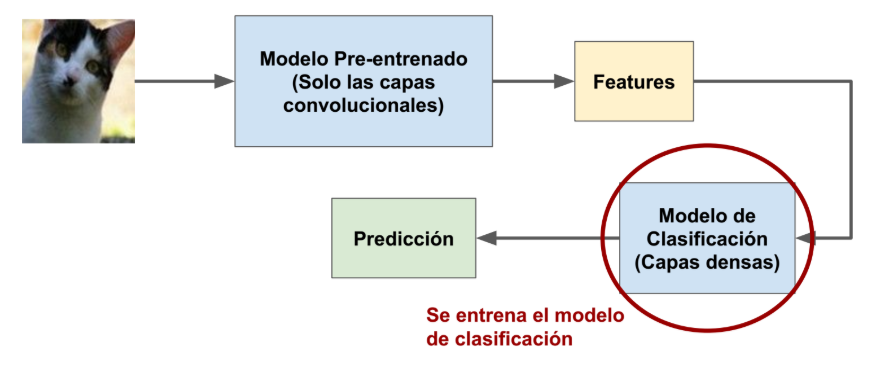

In [ ]:
#Usamos un modelo pre-entrenado ResNet18 con dataset Imagenet
model_fr = models.resnet18(pretrained=True)
for param in model_fr.parameters():
  param.requires_grad = False # Congela los parámetros

#Vamos a cambiar la última capa de la red. La red original fur entrenada con
# 1000 clases. Ahora solo necesitamos 6 neuronas de salida.
# Cambiamos la arquitectura final de la red

num_ft = model_fr.fc.in_features
model_fr.fc = nn.Linear(num_ft, 6)

model_fr = model_fr.to(device)
criterion = nn.CrossEntropyLoss()

#La red original fue entrenada con SGD y un lr inicial de 0.1, el cual decrementaba cada vez que el
# error se estancaba. Nosotros partimos con SGD y un lr bajo, dado que solo queremos tunear la red
# para el nuevo problema

optimizer = torch.optim.SGD(model_fr.parameters(), lr = 0.001, momentum=0.9)

# Empezamos con un número de épocas bajo. A más épocas podemos mejorar el performance
model_fr = train_model(model_fr, criterion, optimizer, num_epochs=30)

#Guardamos la mejor red, en términos de accuracy de validación
torch.save(model_fr.state_dict(), 'resnet18_freezed.pth')

Epoch 0/29
----------
Train Loss: 1.7804  Acc: 0.2500
Val Loss: 1.8889  Acc: 0.1842
Epoch 1/29
----------
Train Loss: 1.6369  Acc: 0.3008
Val Loss: 1.7744  Acc: 0.3158
Epoch 2/29
----------
Train Loss: 1.4495  Acc: 0.4746
Val Loss: 1.6811  Acc: 0.3421
Epoch 3/29
----------
Train Loss: 1.3183  Acc: 0.5169
Val Loss: 1.5756  Acc: 0.4211
Epoch 4/29
----------
Train Loss: 1.2446  Acc: 0.5763
Val Loss: 1.5097  Acc: 0.4474
Epoch 5/29
----------
Train Loss: 1.1933  Acc: 0.5975
Val Loss: 1.4356  Acc: 0.5000
Epoch 6/29
----------
Train Loss: 1.0877  Acc: 0.6314
Val Loss: 1.4456  Acc: 0.5263
Epoch 7/29
----------
Train Loss: 1.0260  Acc: 0.6568
Val Loss: 1.4269  Acc: 0.5000
Epoch 8/29
----------
Train Loss: 1.0270  Acc: 0.6568
Val Loss: 1.3654  Acc: 0.5263
Epoch 9/29
----------
Train Loss: 1.0411  Acc: 0.6271
Val Loss: 1.4077  Acc: 0.5526
Epoch 10/29
----------
Train Loss: 0.9454  Acc: 0.6737
Val Loss: 1.4023  Acc: 0.5263
Epoch 11/29
----------
Train Loss: 0.9072  Acc: 0.6737
Val Loss: 1.3932  Ac

In [ ]:
model_fr = models.resnet18(pretrained=True)
num_ft = model_fr.fc.in_features
model_fr.fc = nn.Linear(num_ft, 6)

model_fr = model_fr.to(device)

model_fr.load_state_dict(torch.load("resnet18_freezed.pth"))
criterion = nn.CrossEntropyLoss()

test_model(model_fr, criterion)

Test Loss: 0.8733  Acc: 0.7027


# Solución 3: Transfer learning con schedulers de learning rate

Una estrategia común al entrenar redes neuronales es cambiar el learning rate bajo algún criterio durante el entrenamiento. Estas estrategias responden a la suposición de que el entrenamiento se estanca por momentos y es necesario cambiar las reglas de actualización para seguir mejorando.

In [ ]:
def train_model_scheduler(model, criterio, optimizer, scheduler, num_epochs = 25):

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    #Train model
    scheduler.step() # Ajusta el LR dinámicamente durante el entrenamiento
    model.train()

    running_loss = 0.0
    running_corrects = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss /len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    #Validation
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0

    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss /len(test_dataset)
    epoch_acc = running_corrects.double() / len(val_dataset)

    print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

  print('Best val accucary: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

Por cada época:
* Llama al scheduler.step() que cambia el learning rate según StepLR
* Durante el entrenamiento hace lo mismo que antes (calcula la loss, hace backpropagation, actualiza parámetros).
* Se realiza la fase de validación.

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 6)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_ft.parameters(), lr = 0.01, momentum=0.9)
"""
Épocas 0–6 → lr = 0.01
Épocas 7–13 → lr = 0.001
Épocas 14–20 → lr = 0.0001
"""
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Reduce el LR cada 7 épocas, múltiplicando por gamma

# Empezamos con un número de épocas bajo. A más épocas podemos mejorar el performance
model_ft = train_model_scheduler(model_ft, criterion, optimizer,exp_lr_scheduler, num_epochs=30)

#Guardamos la mejor red, en términos de accuracy de validación
torch.save(model_ft.state_dict(), 'resnet18_scheduler.pth')

Epoch 0/29
----------


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train Loss: 1.6364 Acc: 0.4025
Val Loss: 0.7544 Acc: 0.5263
Epoch 1/29
----------
Train Loss: 1.0115 Acc: 0.6017
Val Loss: 0.8231 Acc: 0.5263
Epoch 2/29
----------
Train Loss: 0.6962 Acc: 0.7331
Val Loss: 1.0496 Acc: 0.4211
Epoch 3/29
----------
Train Loss: 0.7781 Acc: 0.7627
Val Loss: 0.9703 Acc: 0.5000
Epoch 4/29
----------
Train Loss: 0.7857 Acc: 0.7585
Val Loss: 1.4622 Acc: 0.5263
Epoch 5/29
----------
Train Loss: 0.7869 Acc: 0.7331
Val Loss: 1.5704 Acc: 0.5263
Epoch 6/29
----------
Train Loss: 0.8095 Acc: 0.7203
Val Loss: 1.3075 Acc: 0.5526
Epoch 7/29
----------
Train Loss: 0.5581 Acc: 0.8093
Val Loss: 1.3262 Acc: 0.5526
Epoch 8/29
----------
Train Loss: 0.3696 Acc: 0.8644
Val Loss: 1.3130 Acc: 0.5526
Epoch 9/29
----------
Train Loss: 0.3953 Acc: 0.8856
Val Loss: 1.4080 Acc: 0.6053
Epoch 10/29
----------
Train Loss: 0.3433 Acc: 0.9025
Val Loss: 1.2381 Acc: 0.6316
Epoch 11/29
----------
Train Loss: 0.2630 Acc: 0.9195
Val Loss: 1.3197 Acc: 0.6316
Epoch 12/29
----------
Train Loss: 0

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 6)

model_ft = model_ft.to(device)

model_ft.load_state_dict(torch.load("resnet18_scheduler.pth"))
criterion = nn.CrossEntropyLoss()

test_model(model_ft, criterion)

Test Loss: 1.0639  Acc: 0.7432
